In [383]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

from collections import defaultdict
import math
from sklearn import preprocessing

In [2]:
UNIGRAMS_FILENAME = "attacker_in_conv-bow_features/unigram100.pkl"
BIGRAMS_FILENAME = "attacker_in_conv-bow_features/bigram500.pkl"
UNIGRAMS_LIST = cPickle.load(open(UNIGRAMS_FILENAME, "rb"))
BIGRAMS_LIST = cPickle.load(open(BIGRAMS_FILENAME, "rb"))

In [3]:
with open('feature_extraction/lexicons') as f:
    LEXICONS = json.load(f)

In [522]:
def _get_term_features(document):
    actions = document['action_feature']
    unigrams, bigrams = set([]), set([])
    end_time = 0
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
    actions = sorted(actions, key=lambda k: k['timestamp_in_sec'])[::-1]
    for action in actions:
        if action['timestamp_in_sec'] == end_time or \
            not(action['comment_type'] == 'COMMENT_ADDING' or\
                action['comment_type'] == 'SECTION_CREATION' or\
                action['comment_type'] == 'COMMENT_MODIFICATION'):
            continue
        unigrams = unigrams | set(action['unigrams'])
        bigrams = bigrams | set([tuple(x) for x in action['bigrams']]) 
    f = {}
    f.update(dict(map(lambda x: ("UNIGRAM_" + str(x), 1 if x in unigrams else 0), UNIGRAMS_LIST)))
    f.update(dict(map(lambda x: ("BIGRAM_" + str(x), 1 if tuple(x) in bigrams else 0), BIGRAMS_LIST)))
    return f 

In [503]:
def _get_last_three_action_features(document):
    # Do or don't, verb start sentence
    # quoting
    # giving proof ('according to')
    # ask for suggestion
    actions = document['action_feature']
    unigrams, bigrams = set([]), set([])
    end_time = 0
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
    ret = {'has_positive': 0, 'has_negative': 0, 'has_polite': 0, 'max_length': 0, 'has_deletion' : 0, \
        'has_modification': 0, 'has_restoration': 0, 'has_agree' : 0, 'has_disagree': 0, \
           'has_greetings': 0, 'has_all_cap': 0, 'has_consecutive_?or!': 0, 'verb start': 0, \
           'do/don\'t start': 0, 'quoting': 0, 'past_tense': 0, 'has_thank': 0}
    for key in LEXICONS.keys():
        ret[key] = 0
    actions = sorted(actions, key=lambda k: k['timestamp_in_sec'])[::-1]
    appeared_users = {}
    negative = 0
    positive = 0
    cnt = 3
    for action in actions:
        if not(action['timestamp_in_sec'] == end_time):
            if action['comment_type'] == 'COMMENT_REMOVAL':
                ret['has_deletion'] = 1
                continue
            elif action['comment_type'] == 'COMMENT_RESTORATION':
                ret['has_restoration'] = 1
                continue
            elif action['comment_type'] == 'COMMENT_MODIFICATION':
                ret['has_modification'] = 1
        else:
            continue
        cnt -= 1
        if cnt == 0:
            break
        ret['has_agree'] = ret['has_agree'] or action['has_agree']
        ret['has_disagree'] = ret['has_disagree'] or action['has_disagree']
        
        unigrams = [u.lower() for u in action['unigrams']]
        ret['has_thank'] = ret['has_thank'] or ('thank' in unigrams) or ('thanks' in unigrams) or \
                           ('appreciated' in unigrams)
        ret['has_greetings'] = ret['has_greetings'] or ('hi' in unigrams) or ('hello' in unigrams) or \
                               ('hey' in unigrams)
        
            
        if not(unigrams == []):
            pre_u = unigrams[0]
            for u in unigrams[1:]:
                if u in ['!', '?'] and pre_u in ['!', '?']:
                    ret['has_consecutive_?or!'] = 1
                pre_u = u
                
        if '\'' in unigrams or '\"' in unigrams:
            ret['quoting'] = 1
                
        for s in action['sentences']:
            if s.lower().startswith('do ') or s.lower().startswith('don\'t '):
                ret['do/don\'t start'] = 1
        for p in action['pos_tags']:
            if p[0] == 'VB':
                ret['verb start'] = 1
            if 'VBD' in p:
                ret['past_tense'] = 1
        
        
        for u in action['unigrams']:
            if len(u) > 1 and u == u.upper():
                ret['has_all_cap'] = 1
        
        # Polarity
        polarity = []
        for p in action['polarity']:
            if p['compound'] < -0.5:
                ret['has_negative'] = 1
            if p['compound'] > 0.5:
                ret['has_positive'] = 1

        
        # Politeness
        if action['is_request']:
            if action['politeness_score']['polite'] >= 0.5:
                ret['has_polite'] = 1
        
        for key in LEXICONS.keys():
            if action[key]: ret[key] = 1
    
    new_ret = {}
    for key in ret.keys():
        new_ret['last_three_' + key] = ret[key]
    return new_ret

In [452]:
def _get_action_features(document):
    # Do or don't, verb start sentence
    # quoting
    # giving proof ('according to')
    # ask for suggestion
    actions = document['action_feature']
    unigrams, bigrams = set([]), set([])
    end_time = 0
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
    ret = {'has_positive': 0, 'has_negative': 0, 'has_polite': 0, 'max_length': 0, 'has_deletion' : 0, \
        'has_modification': 0, 'has_restoration': 0, 'has_agree' : 0, 'has_disagree': 0, \
           'has_greetings': 0, 'has_all_cap': 0, 'has_consecutive_?or!': 0, 'verb start': 0, \
           'do/don\'t start': 0, 'quoting': 0, 'past_tense': 0, 'has_thank': 0}
    for key in LEXICONS.keys():
        ret[key] = 0
    actions = sorted(actions, key=lambda k: k['timestamp_in_sec'])[::-1]
    appeared_users = {}
    negative = 0
    positive = 0
    for action in actions:
        if not(action['timestamp_in_sec'] == end_time):
            if action['comment_type'] == 'COMMENT_REMOVAL':
                ret['has_deletion'] = 1
                continue
            elif action['comment_type'] == 'COMMENT_RESTORATION':
                ret['has_restoration'] = 1
                continue
            elif action['comment_type'] == 'COMMENT_MODIFICATION':
                ret['has_modification'] = 1
        else:
            continue
        ret['max_length'] = max(ret['max_length'], action['length'])
        if 'user_text' in action:
            if action['user_text'] in appeared_users:
                continue
            appeared_users[action['user_text']] = 1
        ret['has_agree'] = ret['has_agree'] or action['has_agree']
        ret['has_disagree'] = ret['has_disagree'] or action['has_disagree']
        
        unigrams = [u.lower() for u in action['unigrams']]
        ret['has_thank'] = ret['has_thank'] or ('thank' in unigrams) or ('thanks' in unigrams) or \
                           ('appreciated' in unigrams)
        ret['has_greetings'] = ret['has_greetings'] or ('hi' in unigrams) or ('hello' in unigrams) or \
                               ('hey' in unigrams)
        
            
        if not(unigrams == []):
            pre_u = unigrams[0]
            for u in unigrams[1:]:
                if u in ['!', '?'] and pre_u in ['!', '?']:
                    ret['has_consecutive_?or!'] = 1
                pre_u = u
                
        if '\'' in unigrams or '\"' in unigrams:
            ret['quoting'] = 1
                
        for s in action['sentences']:
            if s.lower().startswith('do ') or s.lower().startswith('don\'t '):
                ret['do/don\'t start'] = 1
        for p in action['pos_tags']:
            if p[0] == 'VB':
                ret['verb start'] = 1
            if 'VBD' in p:
                ret['past_tense'] = 1
        
        
        for u in action['unigrams']:
            if len(u) > 1 and u == u.upper():
                ret['has_all_cap'] = 1
        
        # Polarity
        polarity = []
        for p in action['polarity']:
            if p['compound'] < -0.5:
                ret['has_negative'] = 1
            if p['compound'] > 0.5:
                ret['has_positive'] = 1

        
        # Politeness
        if action['is_request']:
            if action['politeness_score']['polite'] >= 0.5:
                ret['has_polite'] = 1
        
        for key in LEXICONS.keys():
            if action[key]: ret[key] = 1
    
    return ret

In [560]:
def _get_repeatition_features(document):
    actions = document['action_feature']
    unigrams, bigrams = set([]), set([])
    end_time = 0
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
    ret = {}
    replyTo_feat = 0
    self_feat = 0
    for repeat in ['content', 'pos', 'stop']:
        ret['has_%s_repeat'%(repeat)] = 0
        ret['%s_repeat'%(repeat)] = 0
    appeared_users = {}
    repeat_users = {}
    for action in actions:  
        if not('replyTo_id' not in action or action['replyTo_id'] == None):
            replyTo_feat += 1
        last_self = None
        if not('user_id' not in action or action['user_id'] == None):
            for act in actions:
                if not('user_id' not in act or act['user_id'] == None) and \
                   action['user_id'] == act['user_id'] and act['timestamp_in_sec'] < action['timestamp_in_sec']:
                    if last_self == None or last_self['timestamp_in_sec'] < act['timestamp_in_sec']:                               
                        last_self = act
        if action['timestamp_in_sec'] == end_time or \
           action['comment_type'] == 'COMMENT_REMOVAL' or action['comment_type'] == 'COMMENT_RESTORATION' \
            or action['comment_type'] == 'COMMENT_MODIFICATION':
                if not(last_self == None):
                    self_feat += 1
                continue
        if 'user_text' in action:
            appeared_users[action['user_text']] = 1
        if not(last_self == None):
            if 'user_text' in action:
                repeat_users[action['user_text']] = 1
            for repeat in ['content', 'pos', 'stop']:
                cur_repeat = document['conversational_features']['last_self_%s_repeat'%(repeat)][self_feat]
                if cur_repeat > 0:
                    ret['has_%s_repeat'%(repeat)] = 1 
                    if not(repeat == 'pos'):
                        ret['%s_repeat'%(repeat)] = max(ret['%s_repeat'%(repeat)], \
                                            cur_repeat / float(action['length']))
            self_feat += 1
    if len(appeared_users.keys()):
        ret['repeat_percentage'] = len(repeat_users.keys()) / float(len(appeared_users.keys()))
    else:
        ret['repeat_percentage'] = 0
    return ret

In [578]:
def _get_balance_features(document):
    actions = document['action_feature']
    unigrams, bigrams = set([]), set([])
    end_time = 0
    no_users = 0
    user_set = {}
    reply_no = {}
    action_no = defaultdict(int)
    time_gap = {}
    total_actions = 0
    action_dict = {}
    total_user = 0
    lengths = {}

    for action in actions:
        action_dict[action['id']] = action
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
        if 'user_text' in action:
            user_set[action['user_text']] = 1
            reply_no[action['user_text']] = 0
            time_gap[action['user_text']] = 0
            lengths[action['user_text']] = 0
            if not('bot' in action['user_text'].lower()):
                total_user += 1
    no_users = len(user_set.keys())
    ret = {'question_to_question': 0, 'question_to_non_question': 0, 'non_question_to_question': 0, \
            'has_question' : 0}
    replyTo_feat = 0
    total_replyTo = 0
    total_time = 0
    for adoption in ['content', 'pos', 'stop']:
        ret['has_%s_adoption'%(adoption)] = 0
        ret['%s_adoption'%(adoption)] = 0
    
    polarities = []
    total_polarity = 0
    max_depth = 1
    reply_pair = {}
    total_length = 0
    for action in actions:
        if action['timestamp_in_sec'] < end_time and 'user_text' in action:
            action_no[action['user_text']] += 1
            total_actions += 1
        if action['timestamp_in_sec'] == end_time or \
            action['comment_type'] == 'COMMENT_REMOVAL' or action['comment_type'] == 'COMMENT_RESTORATION' \
            or action['comment_type'] == 'COMMENT_MODIFICATION':
                if not('replyTo_id' not in action or action['replyTo_id'] == None):
                    replyTo_feat += 1
                continue
        if 'user_text' in action:
            total_length += action['length']
            lengths[action['user_text']] += action['length']
        if not(action['polarity'] == []):
            polarity = action['polarity'][0]['compound']
        else:
            polarity = 1
        for p in action['polarity']:
            polarity = min(p['compound'], polarity)
        if polarity > 0.5: 
            polarity = 3
        elif polarity < - 0.5:
            polarity = 1
        else: polarity = 2
        polarities.append(polarity)
        total_polarity += polarity
        if not('replyTo_id' not in action or action['replyTo_id'] == None):
            parent = action_dict[action['replyTo_id']]
            d = 2
            cur = parent
            while not('replyTo_id' not in cur or cur['replyTo_id'] == None):
                cur = action_dict[cur['replyTo_id']]
                d += 1
            if 'user_text' in parent and 'user_text' in action:
                reply_pair[(parent['user_text'], action['user_text'])] = 1
            max_depth = max(max_depth, d)
            
            # question or not
            if action['is_request'] and parent['is_request']:
                ret['question_to_question'] = 1
            if not(action['is_request']) and parent['is_request']:
                ret['question_to_non_question'] = 1
            if parent['is_request'] and not(action['is_request']):
                ret['non_question_to_question'] = 1
            if action['is_request']:
                ret['has_question'] = 1
            reply_no[parent['user_text']] += 1
            time_gap[parent['user_text']] += action['timestamp_in_sec'] - parent['timestamp_in_sec']
            total_time += action['timestamp_in_sec'] - parent['timestamp_in_sec']
            total_replyTo += 1
            for adoption in ['content', 'pos', 'stop']:
                cur_adoption = document['conversational_features']['%s_adoption'%(adoption)][replyTo_feat]
                if cur_adoption > 0:
                    ret['has_%s_adoption'%(adoption)] = 1 
                    if not(adoption == 'pos'):
                        ret['%s_adoption'%(adoption)] = max(ret['%s_adoption'%(adoption)], \
                                            cur_adoption / float(action['length']))
            replyTo_feat += 1
    if no_users:
        ret['reply_pairs'] = len(reply_pair.keys()) / (no_users * no_users)
    else:
        ret['reply_pairs'] = 0
    ret['has_reply'] = 0

    if total_replyTo > 0:
        ret['has_reply'] = 1
   #     ret['reply_entropy'] = 0
   #     ret['time_gap_entropy'] = 0


    ret['max_depth'] = max_depth
    lp = len(polarities)
    ret['polarity_entropy'] = (lp == 1)
    if lp > 1:
        for p in polarities:
            ret['polarity_entropy'] -= p / total_polarity * math.log(p / total_polarity) / math.log(lp)
    if ret['polarity_entropy'] > 1:
        ret['polarity_entropy'] = 1
    no_replies = len([x for x in reply_no.keys() if reply_no[x]])
    no_time_gaps = len([x for x in time_gap.keys() if time_gap[x]])
    no_actions = len([x for x in action_no.keys() if action_no[x]])
    no_lengths = len([x for x in lengths.keys() if lengths[x]])
    ret['action_no_entropy'] = (no_actions == 1)
    ret['reply_entropy'] = (no_replies == 1)
    ret['time_gap_entropy'] = (no_time_gaps == 1)
    ret['length_entropy'] = (no_lengths == 1)
    ret['replied_percentage'] = 0
    for user in reply_no.keys():
        if reply_no[user]:
            ret['replied_percentage'] += 1
        if no_replies > 1:
            if reply_no[user] and total_replyTo:
                ret['reply_entropy'] -= reply_no[user] / total_replyTo \
                        * math.log(reply_no[user] / total_replyTo) / math.log(no_replies)
        if no_time_gaps > 1:
            if time_gap[user] and total_time:
                ret['time_gap_entropy'] -= time_gap[user] / total_time \
                        * math.log(time_gap[user] / total_time) / math.log(no_time_gaps)
        if no_actions > 1:
            if action_no[user] and total_actions:
                ret['action_no_entropy'] -= action_no[user] / total_actions \
                        * math.log(action_no[user] / total_actions) / math.log(no_actions)
        if no_lengths > 1:
            if lengths[user] and total_length:
                ret['length_entropy'] -= lengths[user] / total_length \
                        * math.log(lengths[user] / total_length) / math.log(no_lengths)
    ret['replied_percentage'] /= len(reply_no.keys())
    return ret

In [496]:
def documents2feature_vectors(document_features):
    fks = False
    X, y = [], []
    cnt = 0
    max_X = {}
    for pair in document_features:
        conversation, clss = pair
        fs = conversation
        if not fks:
            fks = sorted(fs.keys())
            for f in fks:
                max_X[f] = fs[f]
        fv = [fs[f] for f in fks]
        for f in fks:
            max_X[f] = max(max_X[f], fs[f])
        if cnt % 1000 == 0:
            print(cnt)
        cnt += 1
        X.append(fv)
        y.append(clss)
    for fv in X:
        for ind, f in enumerate(fks):
            if max_X[f] == 0: 
                continue
            fv[ind] /= max_X[f]
    X = csr_matrix(np.asarray(X))
    y = np.asarray(y)
    return X, y, fks

In [565]:
def train_svm(X, y):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [0.0007, 0.0006, 0.0005, 0.0001, 0.001]}]

    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=5, scoring = 'accuracy')
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

#    print(scores.mean())
#    print scores

In [10]:
documents = []
with open('/scratch/wiki_dumps/attacker_in_conv/train.json') as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        documents.append((conversation, clss))       


In [ ]:

"""
173987  unigram total
1341812  bigram total
UNIGRAM: 
14865    10
11517   15
9519    20
5213    50
3262    100

BIGRAM:
53036    10
28668    20
12362    50
6298     100
1058     500
"""

In [ ]:
# 0.573 (+/-0.002) for {'C': 0.0001}
# unigram50, bigram100

# unigram100, bigram100

# unigram50, bigram500

# 0.573 (+/-0.003) for {'C': 0.0001}
# unigram20, bigram100

# 0.573 (+/-0.003) for {'C': 0.0001}
# unigram20, bigram50

In [11]:
random.shuffle(documents)

In [523]:
feature_sets = []
for pair in documents:
    conversation, clss = pair
    feature_set = _get_term_features(conversation)
    feature_sets.append((feature_set, clss))

In [524]:
bow_features = feature_sets

In [525]:
feature_sets = []
for ind, pair in enumerate(documents):
    conversation, clss = pair
    feature_set = _get_action_features(conversation)
    feature_set.update(bow_features[ind][0])
    feature_sets.append((feature_set, clss))

In [526]:
bow_action_features = feature_sets

In [561]:
feature_sets = []
for ind, pair in enumerate(documents):
    conversation, clss = pair
    feature_set = _get_repeatition_features(conversation)
    feature_set.update(bow_action_features[ind][0])
    feature_sets.append((feature_set, clss))

In [569]:
bow_action_repeat_features = feature_sets

In [579]:
feature_sets = []
for ind, pair in enumerate(documents):
    conversation, clss = pair
    feature_set = _get_balance_features(conversation)
    feature_set.update(bow_action_repeat_features[ind][0])
    feature_set.update(_get_last_three_action_features(conversation))
    feature_sets.append((feature_set, clss))

In [580]:
X, y, feature_names = documents2feature_vectors(feature_sets)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [581]:
train_svm(X, y)

Fitting
Best parameters set found on development set:

LinearSVC(C=0.0005, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.644 (+/-0.002) for {'C': 0.0007}
0.644 (+/-0.002) for {'C': 0.0006}
0.645 (+/-0.002) for {'C': 0.0005}
0.635 (+/-0.004) for {'C': 0.0001}
0.644 (+/-0.002) for {'C': 0.001}



/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()

In [ ]:
classifier = svm.LinearSVC(C=0.0001)
classifier.fit(X, y)
plot_coefficients(classifier, feature_names)
# 0.606 (+/-0.004) for {'C': 0.0001}

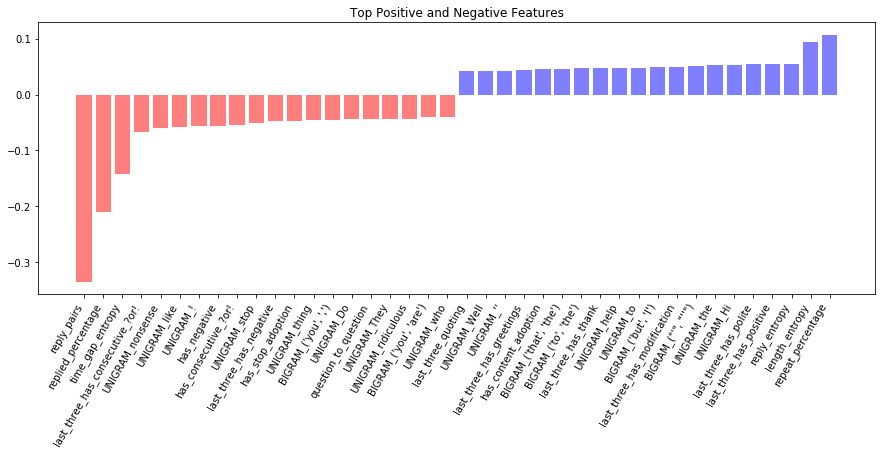

In [582]:
classifier = svm.LinearSVC(C=0.0005)
classifier.fit(X, y)
plot_coefficients(classifier, feature_names)
# bow + action(last 3 actions) + repeat + entropy
# 0.645 (+/-0.002) for {'C': 0.0005}